## Read and pre-process the data
The method to fill in the NULL values is still FFILL need to check in the future

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import operator
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sns.set_theme(context="notebook", font_scale=1.2)

In [2]:
data = pd.read_csv("Loan_Default.csv")
data.drop(columns=["ID", "year"], inplace=True)

In [3]:
data = data.infer_objects()

In [4]:
data['loan_amount'] = data['loan_amount'].astype('float')
data['Credit_Score'] = data['Credit_Score'].astype('float')

In [5]:
data = data.fillna(method="ffill") ## Need to check this for the future

In [6]:
data = data.infer_objects()

In [7]:
data.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

In [8]:
data = pd.get_dummies(data)
data.reset_index(drop=True, inplace=True)

In [9]:
data.dropna(how="any", inplace=True)

In [10]:
data.shape

(148668, 70)

### Standardize the dataset

In [11]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

### PCA
First we look at the Scree-plot to identify the point of infelection for PCA compnents

In [12]:
cov_mat = PCA(n_components=len(data.columns))
cov_mat.fit(data_scaled)

PCA(n_components=70)

In [13]:
eigenvalues = cov_mat.explained_variance_
prop_var = eigenvalues / np.sum(eigenvalues)

In [14]:
prop_var_cumsum = np.cumsum(prop_var)

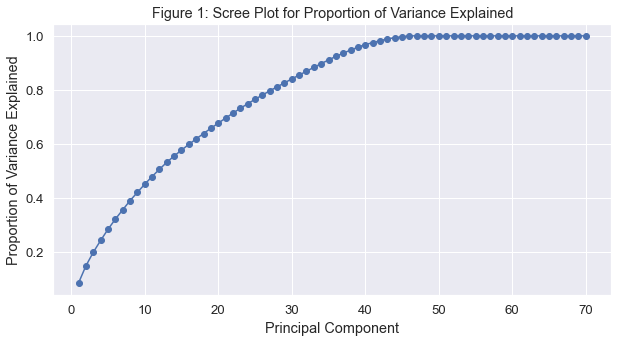

In [15]:
## Scree plots
plt.figure(figsize=[10, 5])
plt.plot(np.arange(1, len(prop_var)+1), prop_var_cumsum, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Figure 1: Scree Plot for Proportion of Variance Explained')
plt.grid(True)

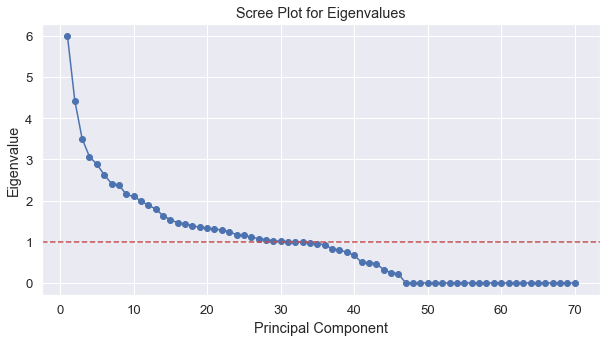

In [16]:
plt.figure(figsize=[10, 5])
plt.plot(np.arange(1, len(eigenvalues)+1), eigenvalues, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot for Eigenvalues')
plt.axhline(y=1, color='r', linestyle='--')
plt.grid(True)

From both percentage of variance explained and eigenvalue we see that we need atleast 30 PCs to explain the data we have, according to the Kaiser and Elbow rules.

In [17]:
pca = PCA(n_components=30)
principalComponents = pca.fit_transform(data_scaled)

In [18]:
## The amount of variance explained by each of the selected components.
pca.explained_variance_ratio_

array([0.08576392, 0.06332111, 0.05004014, 0.04380083, 0.04122423,
       0.03755099, 0.03447814, 0.03403683, 0.03071459, 0.03000846,
       0.02849729, 0.02689332, 0.02576109, 0.0232892 , 0.021989  ,
       0.02086252, 0.02058284, 0.01985316, 0.0193235 , 0.01898956,
       0.01876095, 0.01830514, 0.01780893, 0.01674324, 0.01656056,
       0.01581698, 0.01539072, 0.01496807, 0.0146154 , 0.01442169])

In [19]:
cols = ['PCA_' + str(i) for i in range(1, 31)]
principalDf = pd.DataFrame(data = principalComponents, columns=cols)

In [20]:
# principalDf.to_csv("PCA.csv", index=False)

In [21]:
val = pca.components_.mean(axis = 0)
cols = data.columns
weights = {}
for vals, col in zip(val, cols):
    weights[col] = vals

In [22]:
var_ratios = pca.explained_variance_ratio_
su = var_ratios[:2].sum() * 100 ## Variance from the first two PCs
print(su, "%")

14.9085033792416 %


In [23]:
## Information from each column towards to the components
sorted_d = sorted(weights.items(), key=operator.itemgetter(1))
sorted_d

[('loan_purpose_p3', -0.048544459055475934),
 ('loan_limit_cf', -0.03737011321296914),
 ('approv_in_adv_pre', -0.03684673456126974),
 ('age_65-74', -0.03488711834114513),
 ('age_55-64', -0.034455857971429756),
 ('lump_sum_payment_not_lpsm', -0.034449853163573754),
 ('Region_North-East', -0.03354775769482155),
 ('credit_type_CRIF', -0.027033477054122606),
 ('occupancy_type_pr', -0.024875257638402974),
 ('Credit_Worthiness_l1', -0.02351367352496597),
 ('dtir1', -0.023165253628225958),
 ('open_credit_nopc', -0.018943106875174996),
 ('construction_type_sb', -0.013816341301348197),
 ('Security_Type_direct', -0.013816341301348194),
 ('Secured_by_home', -0.01381634130134819),
 ('total_units_2U', -0.01335346480601093),
 ('Gender_Male', -0.01158356447103458),
 ('Region_central', -0.011121339796365155),
 ('credit_type_EQUI', -0.009181696848532987),
 ('total_units_1U', -0.008431509427068296),
 ('co-applicant_credit_type_CIB', -0.00795672573780187),
 ('loan_purpose_p2', -0.0058924678944084485),
 (

### Varimax rotation

In [24]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_ratio_)
loadings = pd.DataFrame(loadings)

In [25]:
def varimax(loadings, normalize=True, max_iter=500, tolerance=1e-5):
        df = loadings.copy()
        column_names = df.index.values
        index_names = df.columns.values
        n_rows, n_cols = df.shape
        if n_cols < 2:
            return df
        X = df.values
        if normalize:
            normalized_mtx = df.apply(lambda x: np.sqrt(sum(x**2)),
                                      axis=1).values
            X = (X.T / normalized_mtx).T
        rotation_mtx = np.eye(n_cols)

        d = 0
        for _ in range(max_iter):
            old_d = d
            basis = np.dot(X, rotation_mtx)
            transformed = np.dot(X.T, basis**3 - (1.0 / n_rows) *
                                 np.dot(basis, np.diag(np.diag(np.dot(basis.T, basis)))))
            U, S, V = np.linalg.svd(transformed)
            rotation_mtx = np.dot(U, V)
            d = np.sum(S)
            if old_d != 0 and d / old_d < 1 + tolerance:
                break

        X = np.dot(X, rotation_mtx)

        if normalize:
            X = X.T * normalized_mtx
        else:
            X = X.T
        loadings = pd.DataFrame(X, columns=column_names, index=index_names).T

        return loadings, rotation_mtx

In [26]:
rotated_loading, rotationMtx = varimax(loadings)

In [27]:
loadings

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.003168,0.068611,0.039550,0.009418,-0.007707,-0.005995,0.042730,0.012900,0.022255,0.001825,...,-0.008493,-0.013866,-0.007473,0.009113,0.000437,-0.009025,0.012539,0.011678,0.007667,-0.005007
1,-0.000171,-0.014303,-0.032421,0.008108,0.040465,0.047172,0.004979,-0.014107,0.002664,0.001796,...,-0.014786,0.004138,0.006646,-0.026760,0.001978,0.000269,-0.004554,0.015770,0.001405,-0.003076
2,0.000660,-0.052591,-0.020604,0.007380,0.029429,0.044931,0.003992,-0.010660,-0.013994,0.005887,...,-0.001606,0.007077,0.011565,-0.023103,0.001557,-0.005873,-0.003002,0.008367,0.000277,0.000099
3,0.000047,-0.000657,-0.033637,0.008434,-0.013183,0.001884,0.003425,-0.011398,0.002709,0.007652,...,0.006111,-0.013267,-0.001830,0.031459,0.015316,-0.017829,0.043379,0.012854,0.010411,-0.009195
4,0.000338,0.001103,0.029781,-0.004264,0.010757,0.004054,0.014730,0.002525,0.004454,0.005902,...,-0.020339,-0.011215,-0.008547,0.010906,0.001009,0.006586,0.020456,0.018925,0.007483,-0.012648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-0.000068,-0.003870,-0.000343,-0.004102,0.002265,0.000108,-0.001708,0.000234,0.004408,0.001408,...,-0.004958,-0.002907,-0.002001,-0.009800,0.017852,-0.017116,0.004390,-0.012683,0.011325,-0.092486
66,-0.000080,-0.005464,0.010444,0.001888,0.003777,0.003577,-0.004599,-0.003228,-0.000827,-0.000252,...,0.010213,0.000286,0.001454,-0.033132,0.079106,-0.051016,0.011508,-0.034419,-0.005557,0.024707
67,-0.000810,-0.013410,-0.043919,0.032344,-0.051214,-0.012820,0.051655,0.046422,-0.010772,-0.013381,...,-0.007064,-0.001378,-0.005003,-0.003225,-0.012142,0.006169,-0.009317,-0.000188,-0.002427,0.001913
68,0.119468,0.003332,-0.000516,0.000194,-0.000398,0.000014,0.000690,-0.000269,-0.000665,-0.000184,...,-0.000085,0.000103,-0.000002,-0.000137,0.000086,0.000053,0.000071,0.000032,-0.000087,-0.000096
